cup bottle
bottle: 55%
cup: 67%
bottle
3120 4160
5AM

I -; *
-' \20 '5’.

- beads?
Sbombie/f

antl-dandruﬂ shampoo


-1

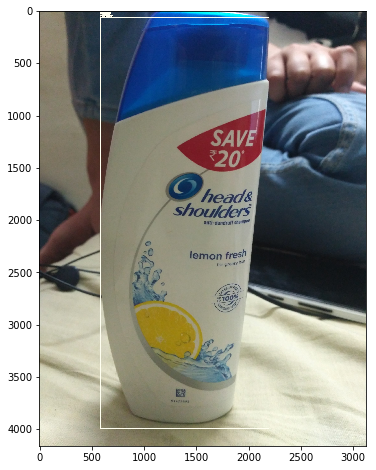

In [17]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import cv2
import numpy as np
from PIL import Image 
#import Image
import pyttsx3
import pytesseract

import zipfile
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt

sys.path.append("..")
pytesseract.pytesseract.tesseract_cmd = 'C:/Program Files (x86)/Tesseract-OCR/tesseract'
from object_detection.utils import ops as utils_ops
if tf.__version__ < '1.4.0':
  raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')
%matplotlib inline
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
import pyttsx3
import numpy as np
import cv2
"""
# Capture video from file
cap = cv2.VideoCapture(1)

while True:

    ret, frame = cap.read()

    if ret == True:

        #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        cv2.imshow('frame',frame)


        if cv2.waitKey(30) & 0xFF == ord('q'):
            cv2.imwrite('C:/Users/hi/AppData/Local/Programs/Python/Python36/models/object_detection/test_images/image9.jpg',frame)
            break

    else:
        break

cap.release()
cv2.destroyAllWindows()

"""


MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'
PATH_TO_LABELS = os.path.join('C:/Users/hi/AppData/Local/Programs/Python/Python36/models/object_detection/data', 'mscoco_label_map.pbtxt')
NUM_CLASSES = 90
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())


detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
    
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)




def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

PATH_TO_TEST_IMAGES_DIR = 'C:/Users/hi/AppData/Local/Programs/Python/Python36/models/object_detection/test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(5, 6) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)




def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict



with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    # Definite input and output Tensors for detection_graph
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    # Each box represents a part of the image where a particular object was detected.
    detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
    detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    for image_path in TEST_IMAGE_PATHS:
        image = Image.open(image_path)
          # the array based representation of the image will be used later in order to prepare the
          # result image with boxes and labels on it.
        image_np = load_image_into_numpy_array(image)
        image_np_expanded = np.expand_dims(image_np, axis=0)
        
        (boxes, scores, classes, num) = sess.run(
            [detection_boxes, detection_scores, detection_classes, num_detections],
            feed_dict={image_tensor: image_np_expanded})
        
        
        li = [category_index.get(value).get('name') for index,value in enumerate(classes[0]) if scores[0,index] > 0.5]
        li1=[]
        for i in li:
            if i not in li1:
                li1.append(i)
        
        
        str1 = " ".join(li1)
        print(str1)
        #print(str1)
        engine = pyttsx3.init()
        engine.say(str1)
        engine.runAndWait()
        #myobj = gTTS(text=str1, lang=language, slow=False)
        #myobj.save("welcome.mp3")
        #os.system("welcome.mp3")
        
        
        output_dict = run_inference_for_single_image(image_np, detection_graph)
        vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
        plt.figure(figsize=IMAGE_SIZE)
        plt.imshow(image_np)
        
        

        

#import image
DEBUG=0
image = cv2.imread('C:/Users/hi/AppData/Local/Programs/Python/Python36/models/object_detection/test_images/image5.jpg')
#im=Image.open('start.jpg')
img_y = len(image)
img_x = len(image[0])
print(img_x,img_y)
#w2,h2=im.size
#print(w2,h2)
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
#cv2.imshow('gray', gray)
#cv2.waitKey(0)
def ii(xx, yy):
    global image, img_y, img_x
    if yy >= img_y or xx >= img_x:
        #print "pixel out of bounds ("+str(y)+","+str(x)+")"
        return 0
    pixel = image[yy][xx]
    return 0.30 * pixel[2] + 0.59 * pixel[1] + 0.11 * pixel[0]
def connected(contour):
    first = contour[0][0]
    last = contour[len(contour) - 1][0]
    return abs(first[0] - last[0]) <= 1 and abs(first[1] - last[1]) <= 1

"""def keep(contour):
    return keep_box(contour) #and connected(contour)

"""

# Whether we should keep the containing box of this
# contour based on it's shape
"""def keep_box(contour):
    xx, yy, w_, h_ = cv2.boundingRect(contour)

    # width and height need to be floats
    w_ *= 1.0
    h_ *= 1.0

    # Test it's shape - if it's too oblong or tall it's
    # probably not a real character
    if w_ / h_ < 0.1 or w_ / h_ > 10:
        if DEBUG:
            print "\t Rejected because of shape: (" + str(xx) + "," + str(yy) + "," + str(w_) + "," + str(h_) + ")" + \
                  str(w_ / h_)
        return False
    
    # check size of the box
    if ((w_ * h_) > ((img_x * img_y) / 5)) or ((w_ * h_) < 15):
        if DEBUG:
            print "\t Rejected because of size"
        return False

    return True"""


#binary
ret,thresh = cv2.threshold(gray,127,255,cv2.THRESH_BINARY_INV)
#cv2.imshow('second', thresh)
#cv2.waitKey(0)
 
#dilation
kernel = np.ones((1,1), np.uint8)
img_dilation = cv2.dilate(thresh, kernel, iterations=1)
#ret1,thresh1 = cv2.threshold(img_dilation,10,255,cv2.THRESH_OTSU)
#cv2.imshow('dilated', img_dilation)

img1=cv2.bitwise_not(img_dilation)
#cv2.imshow('inv', img1)
#cv2.waitKey(0)
#find contours

im2,ctrs, hier = cv2.findContours(img_dilation.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#print ctrs,hier
#sort contours
sorted_ctrs = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])
keepers=[]
#print(sorted_ctrs)
for i, ctr in enumerate(sorted_ctrs):
    """if(i==len(sorted_ctrs)-5):
     	break;"""
    #print(ctr)
    # Get bounding box
    #if (w > 15 and h > 15):
    
    x, y, w, h = cv2.boundingRect(ctr)
    if((w<img_x-8) and (h<img_y-8))and (w > 5 and h > 5):
        keepers.append([ctr, [x, y, w, h]])
        #print(x,y,w,h)
        roi = image[y:y+h, x:x+w]
        cv2.rectangle(image,(x,y),( x + (w), y + (h) ),(0,255,0),2)
        if(w > 5 and h > 5):
            cv2.imwrite('C:/Users/hi/AppData/Local/Programs/Python/Python36/models/pics/{}.png'.format(i), roi)
#ret2,thresh2 = cv2.threshold(image,10,255,cv2.THRESH_OTSU)
new_image = im2.copy()
new_image.fill(255)
#cv2.imwrite("C:/Users/hi/AppData/Local/Programs/Python/Python36/models/filledge.jpg",new_image)
boxes = []

# For each box, find the foreground and background intensities
for index_, (contour_, box) in enumerate(keepers):

    # Find the average intensity of the edge pixels to
    # determine the foreground intensity
    fg_int = 0.0
    for p in contour_:
        fg_int += ii(p[0][0], p[0][1])

    fg_int /= len(contour_)
    if DEBUG:
        print("FG Intensity for #%d = %d" % (index_, fg_int))

    # Find the intensity of three pixels going around the
    # outside of each corner of the bounding box to determine
    # the background intensity
    x_, y_, width, height = box
    bg_int = \
        [
            # bottom left corner 3 pixels
            ii(x_ - 1, y_ - 1),
            ii(x_ - 1, y_),
            ii(x_, y_ - 1),

            # bottom right corner 3 pixels
            ii(x_ + width + 1, y_ - 1),
            ii(x_ + width, y_ - 1),
            ii(x_ + width + 1, y_),

            # top left corner 3 pixels
            ii(x_ - 1, y_ + height + 1),
            ii(x_ - 1, y_ + height),
            ii(x_, y_ + height + 1),

            # top right corner 3 pixels
            ii(x_ + width + 1, y_ + height + 1),
            ii(x_ + width, y_ + height + 1),
            ii(x_ + width + 1, y_ + height)
        ]

    # Find the median of the background
    # pixels determined above
    bg_int = np.median(bg_int)

    if DEBUG:
        print("BG Intensity for #%d = %s" % (index_, repr(bg_int)))

    # Determine if the box should be inverted
    if fg_int >= bg_int:
        fg = 255
        bg = 0
    else:
        fg = 0
        bg = 255

        # Loop through every pixel in the box and color the
        # pixel accordingly
    for x in range(x_, x_ + width):
        for y in range(y_, y_ + height):
            if y >= img_y or x >= img_x:
                if DEBUG:
                    print("pixel out of bounds (%d,%d)" % (y, x))
                continue
            if ii(x, y) > fg_int:
                new_image[y][x] = bg
            else:
                new_image[y][x] = fg

# blur a bit to improve ocr accuracy
#new_image = cv2.blur(new_image, (1, 1))
###kernel = np.ones((1,1), np.uint8)
#new_image = cv2.dilate(new_image, kernel, iterations=1)
###new_image = cv2.blur(new_image, (1, 1))
cv2.imwrite('C:/Users/hi/AppData/Local/Programs/Python/Python36/models/text.jpg', new_image)
#print(pytesseract.image_to_string(Image.open('C:/Users/hi/AppData/Local/Programs/Python/Python36/models/text.jpg')))
engine = pyttsx3.init()
img11=Image.open('C:/Users/hi/AppData/Local/Programs/Python/Python36/models/text.jpg')
print(pytesseract.image_to_string(img11))
engine.say(pytesseract.image_to_string(img11))
engine.runAndWait()
cv2.imshow('marked areas',image)
#cv2.imshow('marked',thresh2)
img1=cv2.bitwise_not(image)
#cv2.imshow('inv_img', img1)
#cv2.imwrite('marked.png',image)
#cv2.imshow('roi1.png',roi1)
cv2.waitKey(0)